<a href="https://colab.research.google.com/github/SERVIR/GEDI_Earthhub_ARSET_Training/blob/main/Module_II_Exploring_Forest_Structure_with_GEDI_L2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Module II: Exploring Forest Structure with GEDI L2B

run the pip install to to load the needed packages

re-run the cell if/when the restart prompt is given

In [1]:
!pip install earthaccess harmony-py hvplot folium geopandas geoviews

Make a new folder to work in and change directory to that location

In [2]:
!mkdir Module_2_GEDI_L2b

!mkdir Module_2_GEDI_L2b/SPB_AOI
!mkdir Module_2_GEDI_L2b/Prescribed_Burn_AOI
!mkdir Module_2_GEDI_L2b/Sewanee_Domain
!mkdir Module_2_GEDI_L2b/PaintRock_AOI

mkdir: cannot create directory ‘Module_2_GEDI_L2b’: File exists
mkdir: cannot create directory ‘Module_2_GEDI_L2b/SPB_AOI’: File exists
mkdir: cannot create directory ‘Module_2_GEDI_L2b/Prescribed_Burn_AOI’: File exists
mkdir: cannot create directory ‘Module_2_GEDI_L2b/Sewanee_Domain’: File exists
mkdir: cannot create directory ‘Module_2_GEDI_L2b/PaintRock_AOI’: File exists


Change directory to that new folder

In [3]:
%cd /content/Module_2_GEDI_L2b

/content/Module_2_GEDI_L2b


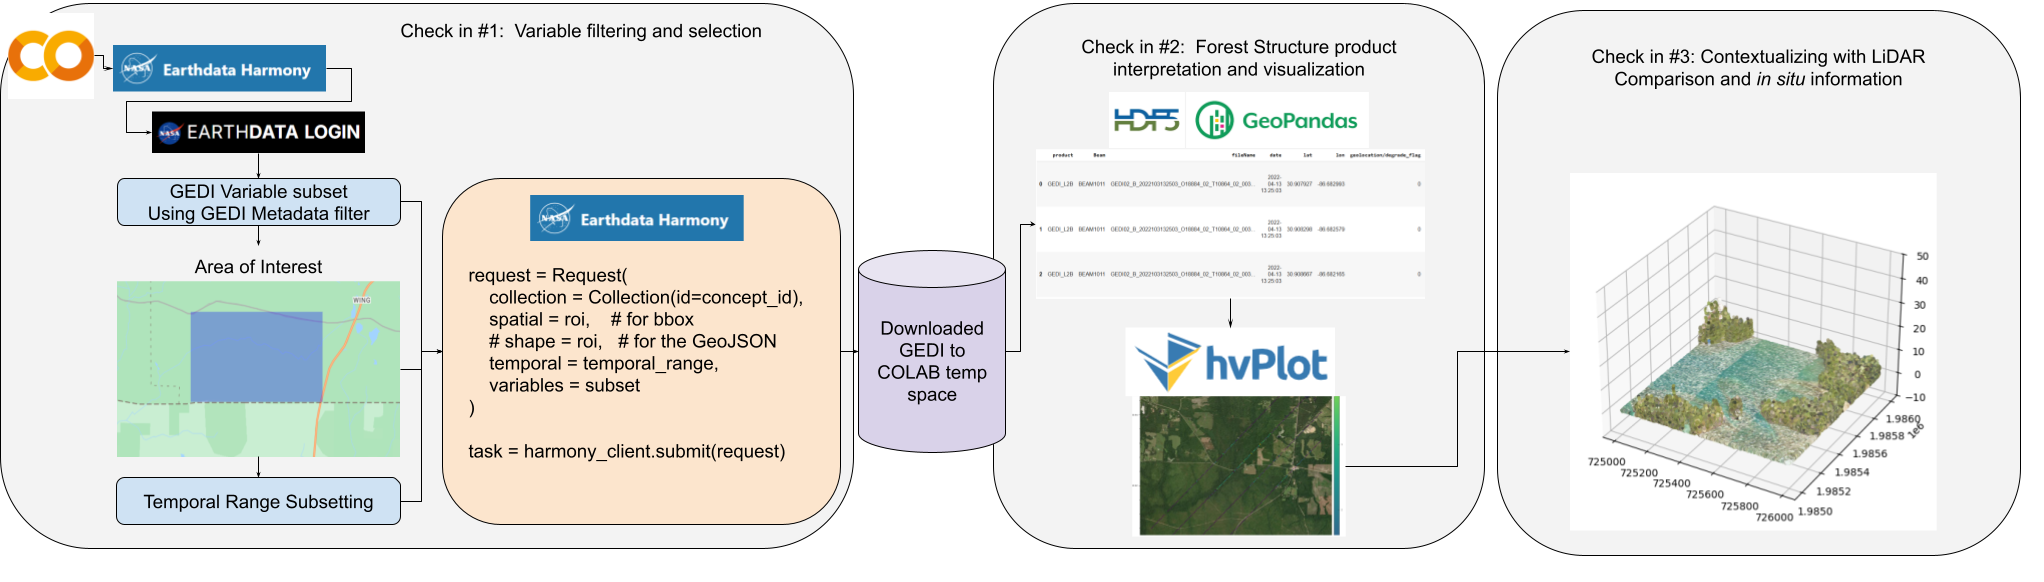

Link to editable workflow (to be removed at the end) https://docs.google.com/drawings/d/1q49Oa-y9W5X25_Qijg0IuSczzcVrcOX5mVfiyIO_UmE/edit

Load the needed packages

In [4]:

from harmony import BBox, Client, Collection, Request, CapabilitiesRequest
import h5py
from datetime import datetime
import json
import earthaccess
import geopandas as gp
import pandas as pd
import numpy as np
import os
from IPython.display import JSON
from shapely.geometry import Point
import hvplot.pandas
import folium
from folium import GeoJson
from IPython.display import display, HTML
import requests
from io import StringIO
from datetime import datetime
import seaborn as sns
from matplotlib import cm, colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable, get_cmap
import textwrap
from mpl_toolkits.mplot3d import Axes3D
# gv.extension('bokeh', 'matplotlib')
from holoviews import opts
import shapely
# import matplotlib.cm as cm
# import matplotlib.colors as colors

os.chdir('../../')

## Authenticate

Pause here and set up your arorund and have your username and password ready for this next section. See the [EarthData Login](https://urs.earthdata.nasa.gov/) if you dont have an account yet.

`earthaccess.login()` is used here to access NASA Earthdata Login (EDL) credentials stored in a .netrc file and allows users to type their credentials and persist them to a .netrc file if one does not exist.

In [5]:
auth = earthaccess.login(persist=True)
# auth.token

Enter your Earthdata Login username: tjm0042
Enter your Earthdata password: ··········


To access data through Harmony service, we need to create a Harmony Client object using either your EDL token or your Earthdata Login credentials. Below, `username` and `password` are directly provided to `Client` function. See [here](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for other options you can create Harmony Client object.

In [6]:
harmony_client = Client(auth=(auth.username, auth.password))

# Visualize our Areas of intres (AOI)

Add relivant biophysical and forest informaiton regarind these sites see  the folder here with the docs to support this: https://drive.google.com/drive/folders/1WvBSUIHy6I05j8s1ZZRarho5qnG2wdnb

In [7]:
# Bring in aois
geojson_urls = {
    "SPB_AOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/SPB_AOI.geojson",
    "Prescribed_Burn_AOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/prescribed_burn_aoi.geojson",
    "Sewanee_Domain": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/Sewanee_Domain.geojson",
    "PaintRockAOI": "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/AOIs/PaintRockAOI.geojson"
}

In [8]:
# Load GeoJSONs into GeoDataFrames and store map HTML
geojson_gdfs = {}
maps_html = []

def create_map_and_gdf(name, url):
    # Get GeoJSON from URL
    geojson_data = requests.get(url).json()

    # Create GeoDataFrame
    gdf = gp.GeoDataFrame.from_features(geojson_data["features"])
    geojson_gdfs[name] = gdf

    # Determine map center
    coords = geojson_data['features'][0]['geometry']['coordinates']
    geom_type = geojson_data['features'][0]['geometry']['type']

    if geom_type == "Polygon":
        coords = coords[0]
    elif geom_type == "MultiPolygon":
        coords = coords[0][0]
    else:
        raise ValueError(f"Unsupported geometry type: {geom_type}")

    lat = sum(pt[1] for pt in coords) / len(coords)
    lon = sum(pt[0] for pt in coords) / len(coords)

    # Create map
    fmap = folium.Map(location=[lat, lon], zoom_start=13, tiles="OpenStreetMap")
    folium.GeoJson(geojson_data, name=name).add_to(fmap)

    # Return rendered HTML
    return fmap._repr_html_()

# Generate maps and GeoDataFrames
for name, url in geojson_urls.items():
    html_map = create_map_and_gdf(name, url)
    maps_html.append(html_map)


In [9]:
# Display maps side by side
html = f"""
<div style="display: flex; flex-wrap: wrap;">
    {''.join([f'<div style="flex: 1; min-width: 400px; margin: 5px;">{m}</div>' for m in maps_html])}
</div>
"""
display(HTML(html))

In [10]:
##Pull out the geopanda dataframes
SPB_AOI = geojson_gdfs["SPB_AOI"]
Prescribed_Burn_AOI = geojson_gdfs["Prescribed_Burn_AOI"]
Sewanee_Domain = geojson_gdfs["Sewanee_Domain"]
PaintRock_AOI = geojson_gdfs["PaintRockAOI"]

In [11]:
# Store all bbox objects in a dictionary for later use
bbox_dict = {}

for name, url in geojson_urls.items():
    gdf = gp.read_file(url)
    minx, miny, maxx, maxy = gdf.total_bounds
    bbox = BBox(minx, miny, maxx, maxy)
    bbox_dict[f"{name}_roi"] = bbox

bbox_dict


{'SPB_AOI_roi': BBox: West:-87.41249365706668, South:34.14940566292299, East:-87.35970778365359, North:34.1864759501938,
 'Prescribed_Burn_AOI_roi': BBox: West:-86.68320982, South:30.99529573, East:-86.62706739, North:31.02423368,
 'Sewanee_Domain_roi': BBox: West:-85.98971714751701, South:35.127110504508586, East:-85.85727611112807, North:35.235639374867105,
 'PaintRockAOI_roi': BBox: West:-86.31006140840377, South:34.769532701151896, East:-86.30307836070996, North:34.77524552146644}

## Get the GEDI Collections Harmony Capabilities

First lets investigate what capabilites Harmony has to request data. Using hte short name `'GEDI02_B'`
('GEDI02_A', 'GEDI02_B', 'GEDI01_B')

view informaiton such as `conceptId` such as variable subsetting, bounding box subsetting, shapefile subsetting, concatenation and reprojection, etc.

In [12]:
capabilities = harmony_client.submit(CapabilitiesRequest(short_name='GEDI02_B'))
print(json.dumps(capabilities, indent=2))

{
  "conceptId": "C2142776747-LPCLOUD",
  "shortName": "GEDI02_B",
  "variableSubset": true,
  "bboxSubset": true,
  "shapeSubset": true,
  "temporalSubset": true,
  "concatenate": false,
  "reproject": false,
  "outputFormats": [
    "application/x-hdf"
  ],
  "services": [
    {
      "name": "sds/trajectory-subsetter",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/S2836723123-XYZ_PROV",
      "capabilities": {
        "subsetting": {
          "temporal": true,
          "bbox": true,
          "shape": true,
          "variable": true
        },
        "output_formats": [
          "application/x-hdf"
        ]
      }
    }
  ],
  "variables": [
    {
      "name": "/BEAM0000/algorithmrun_flag",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647264-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/dz",
      "href": "https://cmr.earthdata.nasa.gov/search/concepts/V2837647474-LPCLOUD"
    },
    {
      "name": "/BEAM0000/ancillary/l2a_al

## Create a Harmony Request

There are several parameters that can be used for the Harmony request. See [the documentation](https://harmony-py.readthedocs.io/en/latest/) and [the introductory Harmony tutorial ](https://github.com/nasa/harmony-py/blob/main/examples/intro_tutorial.ipynb) for more details.



Harmony provides access to services that can transform data from NASA's [Earth Observing Systems Data and Information System (EOSDIS)](https://www.earthdata.nasa.gov/eosdis) Distributed Active Archive Centers (DAAC). [`harmony-py`](https://github.com/nasa/harmony-py) Python package is the recommended way of interacting with Harmony service. This notebook shows how to query and access customized [NASA's LP DAAC](https://lpdaac.usgs.gov/)  GEDI data outputs using [NASA's Harmony Services](https://harmony.earthdata.nasa.gov/).


### GEDI Collection Concept ID

`collection` is a Required parameter. The concept ID, which is the NASA EOSDIS collection ID provided in the Common Metadata Repository [(CMR)](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html) metadata **OR** Product short name (e.g. 'C2142776747-LPCLOUD') can be provided to search for collections.

Below, `concept_id` is saved to a variable.  

In [13]:
print(capabilities['shortName'], ',', capabilities['conceptId'])

concept_id = capabilities['conceptId']
print("concept_id:", concept_id)

GEDI02_B , C2142776747-LPCLOUD
concept_id: C2142776747-LPCLOUD


### GEDI Variable Subset

Take time to explore GEDI variables of importance via the [GEDI l2b dictionary](https://lpdaac.usgs.gov/documents/980/gedi_l2b_dictionary_P003_v2.html)

In [14]:
#See the append_field.txt which hasd a long dictionary of the fields and products of GEDI
#This ictionary will be used to subset our variables of intrest
#Notice this includes'GEDI01_B','GEDI02_A', and 'GEDI02_B'

append_url = "https://raw.githubusercontent.com/SERVIR/GEDI_Earthhub_ARSET_Training/main/append_field.txt"
append_text = requests.get(append_url).text

start_index = append_text.find("{")
end_index = append_text.rfind("}") + 1
dict_str = append_text[start_index:end_index]

append_dict = eval(dict_str)

In [15]:
#Display the dictionary we will use to subset later
append_dict

{'GEDI_L1B': ['geolocation/altitude_instrument',
  'geolocation/local_beam_elevation',
  'tx_sample_start_index',
  'nsemean_odd',
  'ancillary/master_time_epoch',
  'noise_stddev_corrected',
  'tx_pulseflag',
  'geolocation/longitude_bin0_error',
  'selection_stretchers_x',
  'nsemean_even',
  'geolocation/latitude_instrument',
  'geolocation/digital_elevation_model',
  'geolocation/longitude_instrument_error',
  'geolocation/longitude_lastbin_error',
  'tx_egsigma',
  'geolocation/neutat_delay_total_bin0',
  'rx_energy',
  'master_frac',
  'rx_sample_count',
  'rxwaveform',
  'tx_gloc',
  'ancillary/mean_samples',
  'geolocation/longitude_instrument',
  'tx_eggamma_error',
  'rx_offset',
  'tx_egbias_error',
  'geolocation/bounce_time_offset_lastbin',
  'all_samples_sum',
  'geophys_corr/tide_load',
  'geolocation/solar_azimuth',
  'geolocation/mean_sea_surface',
  'geolocation/neutat_delay_total_lastbin',
  'th_left_used',
  'rx_sample_start_index',
  'geophys_corr/tide_ocean',
  'g

In [16]:
# print only the dictionary fo avaible GEDI 2 B products to explore
gedi_l2b = append_dict.get('GEDI_L2B', {})

# Step 4: Print items under 'GEDI_L2B'
print("Items under 'GEDI_L2B':")
for item in gedi_l2b:
    print(item)

Items under 'GEDI_L2B':
rx_processing/rg_eg_flag_a4
rx_processing/rg_eg_gamma_error_a5
rx_processing/rg_eg_gamma_error_a1
rx_processing/rg_error_a3
rx_processing/rg_eg_amplitude_a2
geolocation/local_beam_elevation
ancillary/rg_eg_constraint_center_buffer
rx_processing/rx_energy_a6
ancillary/tx_noise_stddev_multiplier
pgap_theta_z
rx_processing/rg_eg_center_error_a5
rx_processing/pgap_theta_a4
land_cover_data/modis_nonvegetated
geolocation/longitude_bin0_error
rx_processing/rg_error_a1
geolocation/elev_highestreturn
land_cover_data/landsat_water_persistence
land_cover_data/leaf_on_doy
rx_processing/algorithmrun_flag_a5
geolocation/lon_lowestmode
rx_processing/rx_energy_a4
geolocation/digital_elevation_model
rhov
rx_processing/rg_a5
rx_processing/rg_error_a2
geolocation/longitude_lastbin_error
rx_processing/rg_a6
rx_processing/rg_eg_gamma_a1
l2b_quality_flag
rx_processing/rg_eg_amplitude_error_a4
rx_processing/rg_eg_amplitude_a3
rx_processing/pgap_theta_error_a3
land_cover_data/leaf_off_

Select your variables of intrest

In [17]:
#Selecting the 'GEDI02_B' of intrest to then be downloaded
subset_L2B = ['geolocation/lat_lowestmode', 'geolocation/lon_lowestmode', 'geolocation/degrade_flag', 'geolocation/digital_elevation_model','geolocation/elev_lowestmode','geolocation/elev_highestreturn','l2b_quality_flag','rh100', 'pai', 'fhd_normal']

In [18]:
### filter those varibales ofintrest out of the larger list
selected_L2B = []
for s in subset_L2B:
    my_var = [v for v in gedi_l2b if v.endswith(f'{s}')]
    if len(my_var) == 1:
        selected_L2B.append(my_var[0])

    elif len(my_var) > 1:
        my_var = [v for v in my_var if v.startswith(f'{s}')]

        for l in my_var:
            if l not in selected_L2B:
                selected_L2B.append(l)

selected_L2B

['geolocation/lat_lowestmode',
 'geolocation/lon_lowestmode',
 'geolocation/degrade_flag',
 'geolocation/digital_elevation_model',
 'geolocation/elev_lowestmode',
 'geolocation/elev_highestreturn',
 'l2b_quality_flag',
 'rh100',
 'pai',
 'fhd_normal']

Select the subset of your desired beams. For instance, you can only select Full Power beams ('BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011').

In [19]:
#Selecting a few beams: ['BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']
beams = ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

In [20]:
#Append our beams of intrest to our variables of intrest
#the subset list will then be used throughout
subset = []
for b in beams:
    beam_subset = [f'/{b}/{layer}' for layer in selected_L2B]
    [subset.append(i) for i in beam_subset]
subset

['/BEAM0101/geolocation/lat_lowestmode',
 '/BEAM0101/geolocation/lon_lowestmode',
 '/BEAM0101/geolocation/degrade_flag',
 '/BEAM0101/geolocation/digital_elevation_model',
 '/BEAM0101/geolocation/elev_lowestmode',
 '/BEAM0101/geolocation/elev_highestreturn',
 '/BEAM0101/l2b_quality_flag',
 '/BEAM0101/rh100',
 '/BEAM0101/pai',
 '/BEAM0101/fhd_normal',
 '/BEAM0110/geolocation/lat_lowestmode',
 '/BEAM0110/geolocation/lon_lowestmode',
 '/BEAM0110/geolocation/degrade_flag',
 '/BEAM0110/geolocation/digital_elevation_model',
 '/BEAM0110/geolocation/elev_lowestmode',
 '/BEAM0110/geolocation/elev_highestreturn',
 '/BEAM0110/l2b_quality_flag',
 '/BEAM0110/rh100',
 '/BEAM0110/pai',
 '/BEAM0110/fhd_normal',
 '/BEAM1000/geolocation/lat_lowestmode',
 '/BEAM1000/geolocation/lon_lowestmode',
 '/BEAM1000/geolocation/degrade_flag',
 '/BEAM1000/geolocation/digital_elevation_model',
 '/BEAM1000/geolocation/elev_lowestmode',
 '/BEAM1000/geolocation/elev_highestreturn',
 '/BEAM1000/l2b_quality_flag',
 '/BEAM

# Create Request Task and download spatially and vairable subseted H5 Files

These code block creates request tasks via harmony and downloads them to the set directories.
The AOI, time period, and subset variables are used to create the the request


In [21]:
# Define temporal range
temporal_range = {'start': datetime(2019, 4, 1),
                  'stop': datetime(2022, 12, 30)}

In [22]:
# Corresponding output directories
output_dirs = [
    '/content/Module_2_GEDI_L2b/SPB_AOI',
    '/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI',
    '/content/Module_2_GEDI_L2b/PaintRock_AOI',
    '/content/Module_2_GEDI_L2b/Sewanee_Domain'
]

In [23]:
# Loop through paired spatial ROIs and directories
for (spatial, out_dir) in zip(bbox_dict.keys(), output_dirs):
    print(f"\nSubmitting request for: {out_dir}")

    request = Request(
        collection=Collection(id=concept_id),
        spatial=bbox_dict[spatial],  # Use the corresponding BBox from the dictionary
        temporal=temporal_range,
        variables=subset
    )

    print("Check if the request payload is valid:", request.is_valid())

    task = harmony_client.submit(request)
    print(f'Harmony request ID: {task}')

    print('Processing your Harmony request:')
    task_json = harmony_client.result_json(task, show_progress=True)

    results = harmony_client.download_all(task, directory=out_dir, overwrite=True)
    file_names = [f.result() for f in results]

    print(f"Download completed for {out_dir}")



Submitting request for: /content/Module_2_GEDI_L2b/SPB_AOI
Check if the request payload is valid: True
Harmony request ID: cbac7fa4-32bc-4d2e-8a3f-a378d7d6cf01
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]


/content/Module_2_GEDI_L2b/SPB_AOI/102482178_GEDI02_B_2019263001316_O04365_02_T03688_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482177_GEDI02_B_2019230201557_O03866_03_T02897_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482179_GEDI02_B_2019298172214_O04919_03_T01627_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482181_GEDI02_B_2020084054801_O07253_03_T01627_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482182_GEDI02_B_2020088041519_O07314_03_T02897_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482183_GEDI02_B_2020196021509_O08987_02_T05264_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482184_GEDI02_B_2020319084747_O10898_03_T05743_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482185_GEDI02_B_2020339010136_O11203_03_T08589_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482187_GEDI02_B_2021051175317_O12423_03_T05743_02_003_01_V

 [ Processing:   0% ] |                                                   | [/]

Harmony request ID: ef7d8340-e05a-4fa0-ba1b-fd3a796683cf
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]


/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI/102482249_GEDI02_B_2019193033651_O03281_02_T00750_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI/102482251_GEDI02_B_2019309131720_O05087_03_T03907_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI/102482259_GEDI02_B_2022011020145_O17450_02_T06442_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/Prescribed_Burn_AOI/102482258_GEDI02_B_2021297164948_O16235_03_T09599_02_003_01_V002_subsetted.h5
Download completed for /content/Module_2_GEDI_L2b/Prescribed_Burn_AOI

Submitting request for: /content/Module_2_GEDI_L2b/PaintRock_AOI
Check if the request payload is valid: True


 [ Processing:   0% ] |                                                   | [/]

Harmony request ID: 7999dcd8-c042-45c7-9456-cfd6b02de999
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]


/content/Module_2_GEDI_L2b/PaintRock_AOI/102482274_GEDI02_B_2019138014405_O02426_02_T03841_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/PaintRock_AOI/102482273_GEDI02_B_2019122150008_O02186_03_T04733_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/PaintRock_AOI/102482275_GEDI02_B_2019209043943_O03530_03_T03157_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/PaintRock_AOI/102482276_GEDI02_B_2019210205202_O03556_02_T00995_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/PaintRock_AOI/102482278_GEDI02_B_2019312044317_O05128_02_T02571_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/PaintRock_AOI/102482279_GEDI02_B_2019337015939_O05514_03_T01887_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/PaintRock_AOI/102482280_GEDI02_B_2020182144232_O08778_03_T00311_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/PaintRock_AOI/102482281_GEDI02_B_2020196021509_O08987_02_T05264_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/PaintRock_AOI/1024822

 [ Processing:   0% ] |                                                   | [/]

Harmony request ID: 6c9208ea-8b09-47b7-ae0e-2aa81bc74973
Processing your Harmony request:


 [ Processing: 100% ] |###################################################| [|]


/content/Module_2_GEDI_L2b/Sewanee_Domain/102482353_GEDI02_B_2019289134028_O04777_02_T05417_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/Sewanee_Domain/102482352_GEDI02_B_2019168204100_O02904_03_T04427_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/Sewanee_Domain/102482356_GEDI02_B_2021162214800_O14146_03_T11236_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/Sewanee_Domain/102482361_GEDI02_B_2022183060859_O20120_02_T05417_02_003_02_V002_subsetted.h5
/content/Module_2_GEDI_L2b/Sewanee_Domain/102482364_GEDI02_B_2022348194735_O22688_03_T11236_02_003_01_V002_subsetted.h5
Download completed for /content/Module_2_GEDI_L2b/Sewanee_Domain


In [24]:
## confirm files are in the right spots
!find /content/Module_2_GEDI_L2b

/content/Module_2_GEDI_L2b
/content/Module_2_GEDI_L2b/SPB_AOI
/content/Module_2_GEDI_L2b/SPB_AOI/102482181_GEDI02_B_2020084054801_O07253_03_T01627_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482190_GEDI02_B_2021292112336_O16154_02_T10956_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482178_GEDI02_B_2019263001316_O04365_02_T03688_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482184_GEDI02_B_2020319084747_O10898_03_T05743_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482179_GEDI02_B_2019298172214_O04919_03_T01627_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482182_GEDI02_B_2020088041519_O07314_03_T02897_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482196_GEDI02_B_2022123130656_O19194_03_T08589_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI/102482187_GEDI02_B_2021051175317_O12423_03_T05743_02_003_01_V002_subsetted.h5
/content/Module_2_GEDI_L2b/SPB_AOI

Function is defined to create a DataFrame from our HDF5 Harmony subset file. Next, `GeoDataFrame` is created for all the downloaded subset file.

Explore one of the downloaded h5 files

In [25]:
import os
import h5py

# Directory containing the HDF5 files
folder_path = '/content/Module_2_GEDI_L2b/SPB_AOI'

# Get the first .h5 file in the directory
files = [f for f in os.listdir(folder_path) if f.endswith('.h5')]
if not files:
    raise FileNotFoundError("No .h5 files found in the directory.")

first_file_path = os.path.join(folder_path, files[0])
print(f"Using file: {first_file_path}")

# Open and explore the HDF5 file
with h5py.File(first_file_path, 'r') as f:
    print("\nTop-level groups:")
    print(list(f.keys()))

    print("\nAvailable beams:")
    beams_found = [k for k in f.keys() if k.startswith("BEAM")]
    print(beams_found)

    for beam in beams_found:
        print(f"\nVariables in {beam}:")
        print(list(f[beam].keys()))



Using file: /content/Module_2_GEDI_L2b/SPB_AOI/102482181_GEDI02_B_2020084054801_O07253_03_T01627_02_003_01_V002_subsetted.h5

Top-level groups:
['BEAM1000', 'BEAM1011', 'METADATA']

Available beams:
['BEAM1000', 'BEAM1011']

Variables in BEAM1000:
['fhd_normal', 'geolocation', 'l2b_quality_flag', 'pai', 'rh100']

Variables in BEAM1011:
['fhd_normal', 'geolocation', 'l2b_quality_flag', 'pai', 'rh100']


In [26]:
### open each h5 file grab the data and convert it to a table
def h5_to_dataframe(ds, beams, vars):
    gedi_ds = h5py.File(ds, 'r')
    product = gedi_ds['METADATA']['DatasetIdentification'].attrs['shortName']
    fileName = gedi_ds['METADATA']['DatasetIdentification'].attrs['fileName']
    date = datetime.strptime(fileName.rsplit('_')[2], '%Y%j%H%M%S').strftime('%Y-%m-%d %H:%M:%S')

    df_beam = pd.DataFrame(columns=vars)

    for b in beams:
        data_dic = {}
        try:
            for v in vars:
                value = gedi_ds[f'{b}/{v}'][()]
                data_dic[v] = value.tolist()
            beam_df = pd.DataFrame(data_dic)
            beam_df.insert(0, 'product', product)
            beam_df.insert(1, 'Beam', b)
            beam_df.insert(2, 'fileName', fileName)
            beam_df.insert(3, 'date', date)
            df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
        except Exception as e:
            print(f"    ⚠️ Skipping beam {b} in file {fileName} due to error: {e}")
            continue

    return df_beam.reset_index(drop=True)

# Storage
geo_dfs = {}

# Loop through folders
for folder in output_dirs:
    print(f"Processing folder: {folder}")
    file_names = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.h5')]
    l2b_df = pd.DataFrame()

    for file in file_names:
        print(f"  Reading file: {file}")
        try:
            gedi_subset = h5_to_dataframe(file, beams, subset_L2B)
            l2b_df = pd.concat([l2b_df, gedi_subset], ignore_index=True)
        except Exception as e:
            print(f"    ⚠️ Skipping {file} due to error: {e}")
            continue

    if not l2b_df.empty:
        l2b_df = l2b_df.rename(columns={
            'geolocation/lat_lowestmode': 'lat',
            'geolocation/lon_lowestmode': 'lon'
        })
        l2b_df = gp.GeoDataFrame(
            l2b_df,
            geometry=l2b_df.apply(lambda row: Point(row.lon, row.lat), axis=1),
            crs="EPSG:4326"
        )
        geo_dfs[os.path.basename(folder)] = l2b_df
    else:
        print(f"    ⚠️ No valid data found in {folder}")


Processing folder: /content/Module_2_GEDI_L2b/SPB_AOI
  Reading file: /content/Module_2_GEDI_L2b/SPB_AOI/102482181_GEDI02_B_2020084054801_O07253_03_T01627_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM0101 in file GEDI02_B_2020084054801_O07253_03_T01627_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam BEAM0110 in file GEDI02_B_2020084054801_O07253_03_T01627_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
  Reading file: /content/Module_2_GEDI_L2b/SPB_AOI/102482190_GEDI02_B_2021292112336_O16154_02_T10956_02_003_01_V002_subsetted.h5


/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)


  Reading file: /content/Module_2_GEDI_L2b/SPB_AOI/102482178_GEDI02_B_2019263001316_O04365_02_T03688_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM0101 in file GEDI02_B_2019263001316_O04365_02_T03688_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam BEAM0110 in file GEDI02_B_2019263001316_O04365_02_T03688_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam BEAM1000 in file GEDI02_B_2019263001316_O04365_02_T03688_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
  Reading file: /content/Module_2_GEDI_L2b/SPB_AOI/102482184_GEDI02_B_2020319084747_O10898_03_T05743_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM1000 in file GEDI02_B_2020319084747_O10898_03_T05743_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam BEAM1011 in file GEDI02_B_2020319084747_O

/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA column

  Reading file: /content/Module_2_GEDI_L2b/SPB_AOI/102482182_GEDI02_B_2020088041519_O07314_03_T02897_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/SPB_AOI/102482196_GEDI02_B_2022123130656_O19194_03_T08589_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/SPB_AOI/102482187_GEDI02_B_2021051175317_O12423_03_T05743_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM1000 in file GEDI02_B_2021051175317_O12423_03_T05743_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam BEAM1011 in file GEDI02_B_2021051175317_O12423_03_T05743_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'


/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA column

  Reading file: /content/Module_2_GEDI_L2b/SPB_AOI/102482195_GEDI02_B_2022093011111_O18721_03_T01627_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM0101 in file GEDI02_B_2022093011111_O18721_03_T01627_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam BEAM0110 in file GEDI02_B_2022093011111_O18721_03_T01627_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
  Reading file: /content/Module_2_GEDI_L2b/SPB_AOI/102482192_GEDI02_B_2022042210253_O17943_03_T02897_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/SPB_AOI/102482183_GEDI02_B_2020196021509_O08987_02_T05264_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM0110 in file GEDI02_B_2020196021509_O08987_02_T05264_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam BEAM1000 in file GEDI02_B_2020196021509_O08987_02_T05264_02_003_01_V002.h5 due to 

/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)


Processing folder: /content/Module_2_GEDI_L2b/Prescribed_Burn_AOI
  Reading file: /content/Module_2_GEDI_L2b/Prescribed_Burn_AOI/102482259_GEDI02_B_2022011020145_O17450_02_T06442_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM0101 in file GEDI02_B_2022011020145_O17450_02_T06442_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
  Reading file: /content/Module_2_GEDI_L2b/Prescribed_Burn_AOI/102482249_GEDI02_B_2019193033651_O03281_02_T00750_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM0101 in file GEDI02_B_2019193033651_O03281_02_T00750_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam BEAM0110 in file GEDI02_B_2019193033651_O03281_02_T00750_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam BEAM1000 in file GEDI02_B_2019193033651_O03281_02_T00750_02_003_01_V002.h5 due to error: 'Unable to synchronously open ob

/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA column

  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482302_GEDI02_B_2022352181058_O22749_03_T07426_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482291_GEDI02_B_2022016072349_O17531_03_T07426_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482278_GEDI02_B_2019312044317_O05128_02_T02571_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM1011 in file GEDI02_B_2019312044317_O05128_02_T02571_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482275_GEDI02_B_2019209043943_O03530_03_T03157_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482300_GEDI02_B_2022289120454_O21768_02_T09533_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482292_GEDI02_B_2022025202812_O17679_02_T08110_02_003_01_V002_subsetted.h5
  Reading file: /con

/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA column

  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482296_GEDI02_B_2022139064237_O19438_03_T04580_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM1000 in file GEDI02_B_2022139064237_O19438_03_T04580_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam BEAM1011 in file GEDI02_B_2022139064237_O19438_03_T04580_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482285_GEDI02_B_2021139070445_O13780_03_T06003_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482290_GEDI02_B_2021298160332_O16250_03_T10425_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482276_GEDI02_B_2019210205202_O03556_02_T00995_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482293_GEDI02_B_2022062130418_O18248_03_T10425_02_003_01_V00

/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA column

  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482281_GEDI02_B_2020196021509_O08987_02_T05264_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482274_GEDI02_B_2019138014405_O02426_02_T03841_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482279_GEDI02_B_2019337015939_O05514_03_T01887_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482294_GEDI02_B_2022068034341_O18335_02_T00995_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482280_GEDI02_B_2020182144232_O08778_03_T00311_02_003_01_V002_subsetted.h5
  Reading file: /content/Module_2_GEDI_L2b/PaintRock_AOI/102482283_GEDI02_B_2021131101046_O13658_03_T04580_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM1000 in file GEDI02_B_2021131101046_O13658_03_T04580_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam

/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA column

Processing folder: /content/Module_2_GEDI_L2b/Sewanee_Domain
  Reading file: /content/Module_2_GEDI_L2b/Sewanee_Domain/102482364_GEDI02_B_2022348194735_O22688_03_T11236_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM0101 in file GEDI02_B_2022348194735_O22688_03_T11236_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam BEAM1000 in file GEDI02_B_2022348194735_O22688_03_T11236_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
    ⚠️ Skipping beam BEAM1011 in file GEDI02_B_2022348194735_O22688_03_T11236_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component not found)'
  Reading file: /content/Module_2_GEDI_L2b/Sewanee_Domain/102482352_GEDI02_B_2019168204100_O02904_03_T04427_02_003_01_V002_subsetted.h5
    ⚠️ Skipping beam BEAM0101 in file GEDI02_B_2019168204100_O02904_03_T04427_02_003_01_V002.h5 due to error: 'Unable to synchronously open object (component

/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_beam = pd.concat([df_beam, beam_df], ignore_index=True)
/tmp/ipython-input-26-1853161237.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA column

In [27]:
#save the dataframes as csvs
for out_dir in output_dirs:
    # Extract folder name only (e.g., 'SPB_AOI')
    aoi_name = os.path.basename(out_dir)

    # Get corresponding GeoDataFrame
    gdf = geo_dfs.get(aoi_name)

    if gdf is not None and not gdf.empty:
        # Define CSV path
        csv_path = os.path.join(out_dir, f"{aoi_name}_GEDI_L2B.csv")

        # Drop the geometry column (optional, if you only want flat CSV)
        gdf_no_geom = gdf.drop(columns='geometry')

        # Save as CSV
        gdf_no_geom.to_csv(csv_path, index=False)
        print(f"✅ Saved: {csv_path}")
    else:
        print(f"⚠️ Skipped: {aoi_name} (no data)")


✅ Saved: /content/Module_2_GEDI_L2b/SPB_AOI/SPB_AOI_GEDI_L2B.csv
✅ Saved: /content/Module_2_GEDI_L2b/Prescribed_Burn_AOI/Prescribed_Burn_AOI_GEDI_L2B.csv
✅ Saved: /content/Module_2_GEDI_L2b/PaintRock_AOI/PaintRock_AOI_GEDI_L2B.csv
✅ Saved: /content/Module_2_GEDI_L2b/Sewanee_Domain/Sewanee_Domain_GEDI_L2B.csv


In [28]:
##pull the dataframes from the dict created above

SPB_AOI = geo_dfs.get('SPB_AOI', gp.GeoDataFrame())
Prescribed_Burn_AOI = geo_dfs.get('Prescribed_Burn_AOI', gp.GeoDataFrame())
PaintRock_AOI = geo_dfs.get('PaintRock_AOI', gp.GeoDataFrame())
Sewanee_Domain = geo_dfs.get('Sewanee_Domain', gp.GeoDataFrame())

Sewanee_Domain.head()

lat        lon geolocation/degrade_flag  \
0  34.775068 -86.308219                        0   
1  34.774716 -86.307763                        0   
2  34.774364 -86.307307                        0   
3  34.774012 -86.306852                        0   
4  34.773660 -86.306396                        0   

   geolocation/digital_elevation_model  geolocation/elev_lowestmode  \
0                           251.722763                  -265.849091   
1                           234.302673                  -265.302551   
2                           235.548264                  -265.337799   
3                           222.751709                  -265.753448   
4                           230.090591                  -265.876648   

   geolocation/elev_highestreturn l2b_quality_flag rh100     pai  fhd_normal  \
0                     -265.849091                0     0 -9999.0     -9999.0   
1                     -265.302551                0     0 -9999.0     -9999.0   
2                     -265.337799                0     0 -9999.0     -9999.0   
3                     -265.753448                0     0 -9999.0     -9999.0   
4                     -265.876648                0     0 -9999.0     -9999.0   

    product      Beam                                           fileName  \
0  GEDI_L2B  BEAM0110  GEDI02_B_2022348194735_O22688_03_T11236_02_003...   
1  GEDI_L2B  BEAM0110  GEDI02_B_2022348194735_O22688_03_T11236_02_003...   
2  GEDI_L2B  BEAM0110  GEDI02_B_2022348194735_O22688_03_T11236_02_003...   
3  GEDI_L2B  BEAM0110  GEDI02_B_2022348194735_O22688_03_T11236_02_003...   
4  GEDI_L2B  BEAM0110  GEDI02_B_2022348194735_O22688_03_T11236_02_003...   

                  date                    geometry  
0  2022-12-14 19:47:35  POINT (-86.30822 34.77507)  
1  2022-12-14 19:47:35  POINT (-86.30776 34.77472)  
2  2022-12-14 19:47:35  POINT (-86.30731 34.77436)  
3  2022-12-14 19:47:35  POINT (-86.30685 34.77401)  
4  2022-12-14 19:47:35   POINT (-86.3064 34.77366)

# Explore Quality Filtering

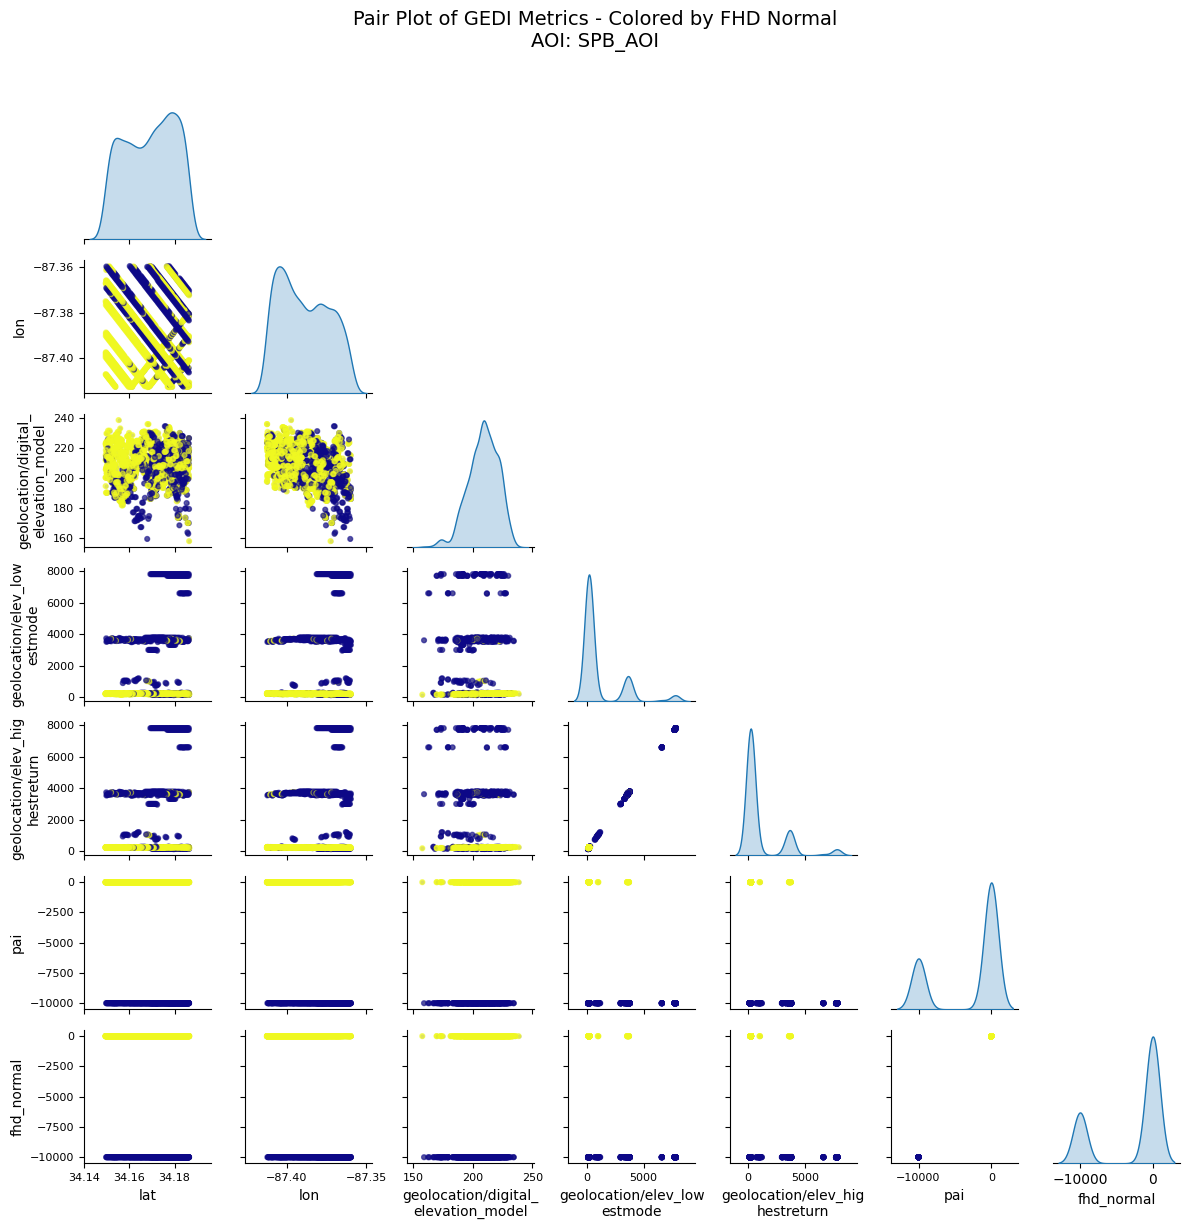

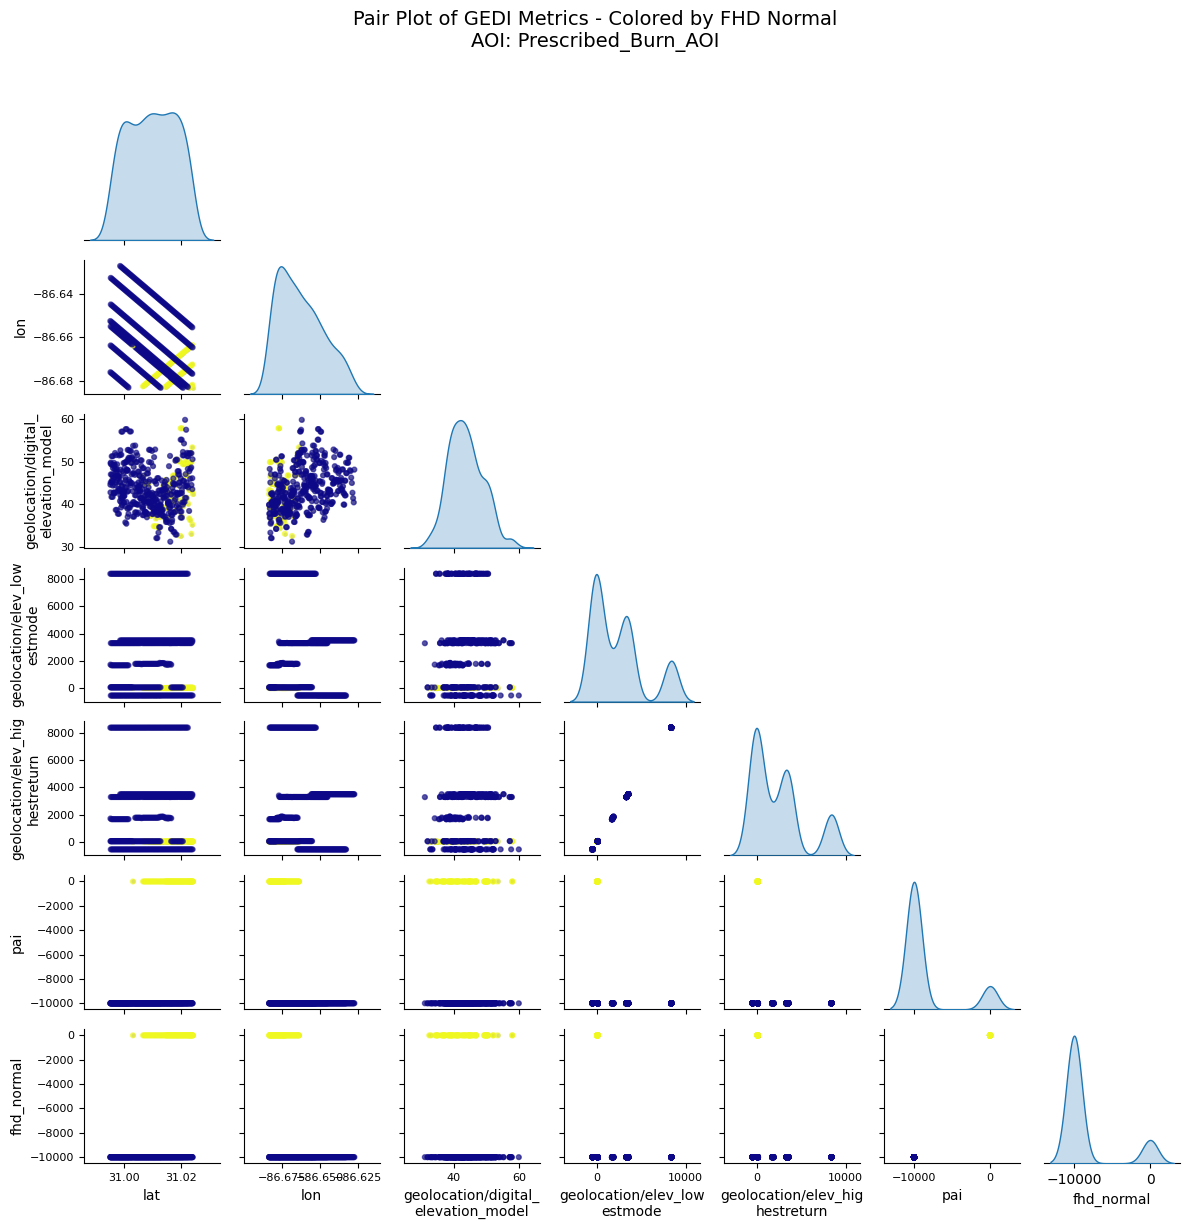

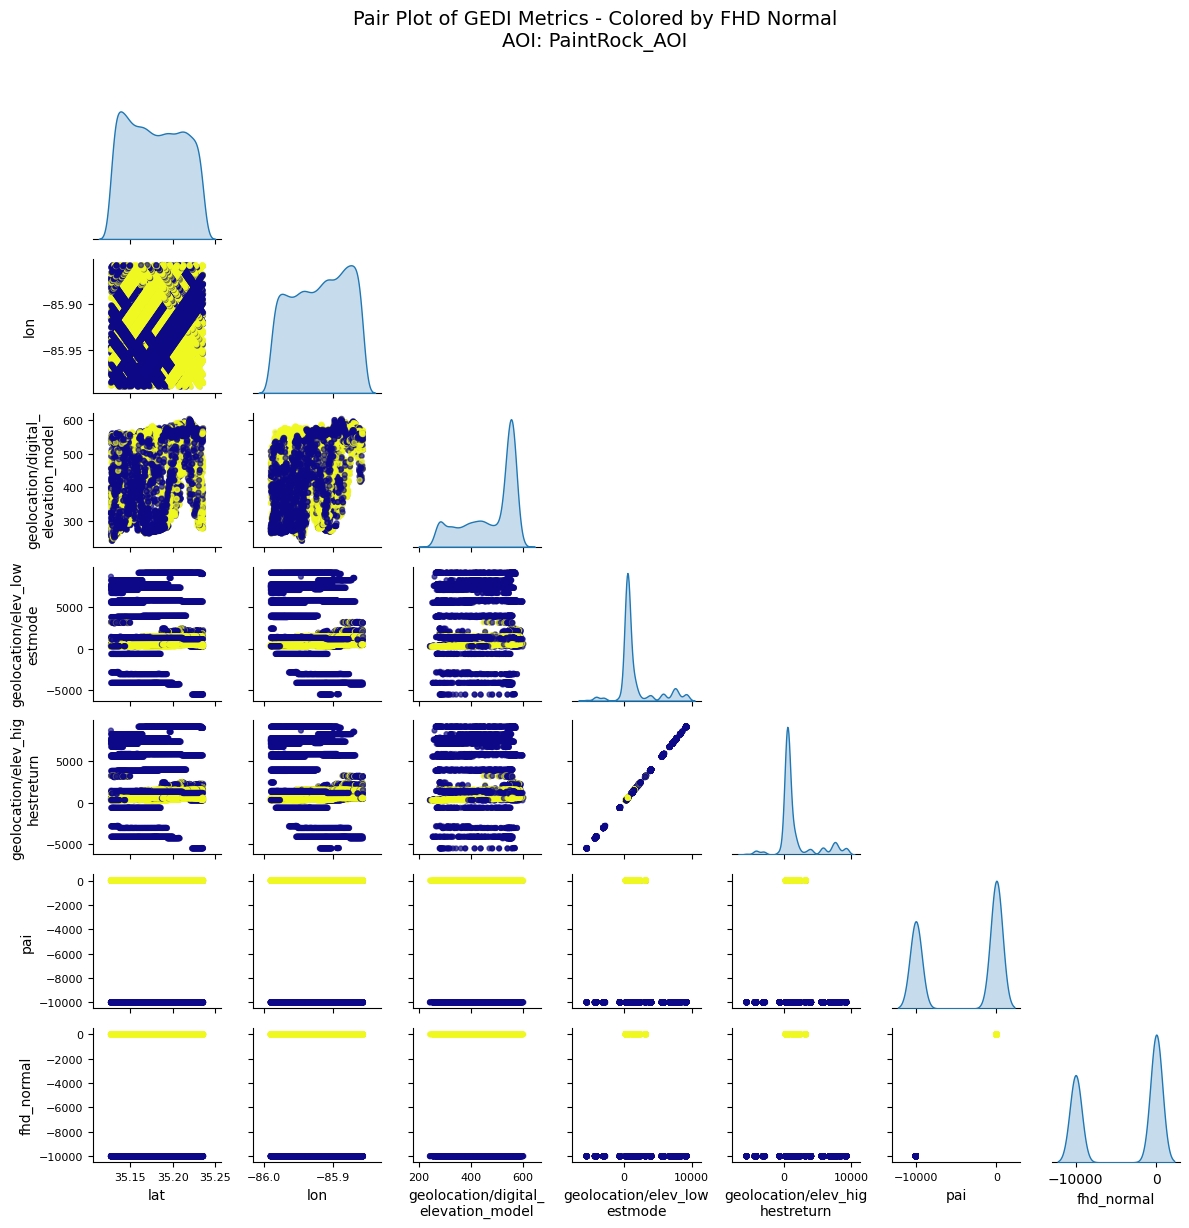

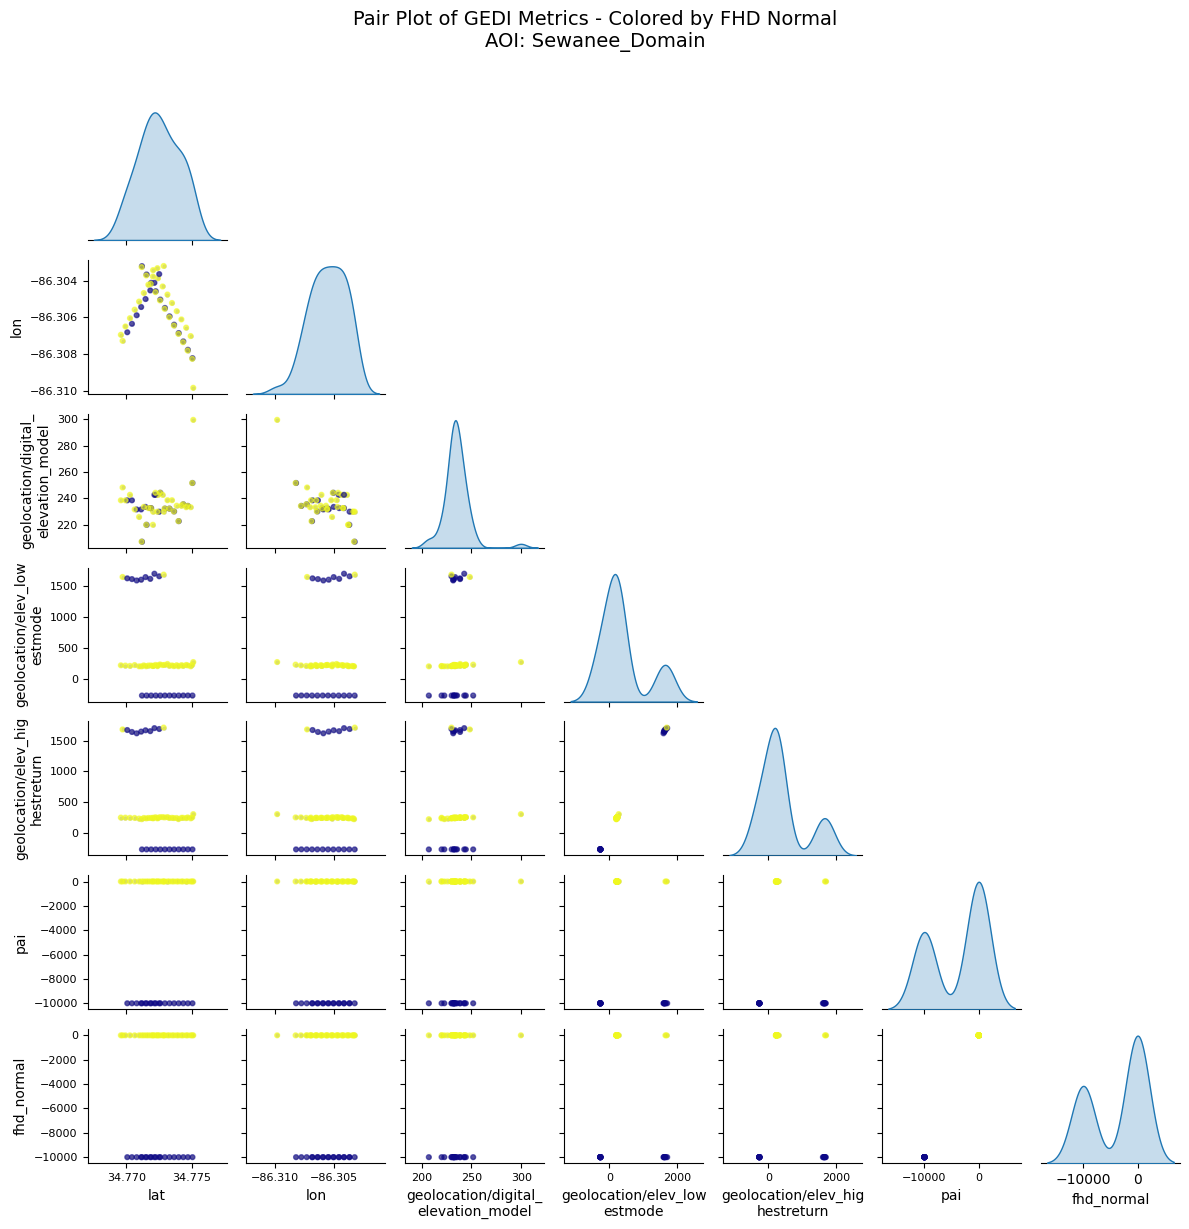

In [46]:
#### Pairplot on the filtered datasets

# Modern colormap access
cmap = mpl.colormaps['plasma']

for aoi_name, gdf in geo_dfs.items():
    numeric_cols = gdf.select_dtypes(include=[np.number]).columns.tolist()
    if 'fhd_normal' not in numeric_cols or gdf.empty:
        print(f"Skipping {aoi_name} (no numeric data or missing fhd_normal)")
        continue

    # Clean data
    plot_df = gdf[numeric_cols].dropna()

    # Normalize for coloring
    norm = Normalize(vmin=plot_df['fhd_normal'].min(), vmax=plot_df['fhd_normal'].max())
    colors = cmap(norm(plot_df['fhd_normal'].values))

    # Create base pairplot
    pair_grid = sns.pairplot(
        plot_df,
        corner=True,
        diag_kind='kde',
        plot_kws={'s': 10, 'alpha': 0.5, 'color': 'gray'},
        diag_kws={'fill': True}
    )

    # Resize figure for clarity
    pair_grid.fig.set_size_inches(12, 12)

    # Overlay color-coded scatter
    for i, j in zip(*np.tril_indices_from(pair_grid.axes, -1)):
        ax = pair_grid.axes[i, j]
        if ax:
            x = plot_df.iloc[:, j]
            y = plot_df.iloc[:, i]
            ax.scatter(x, y, c=colors, s=12, alpha=0.6)

            # Verbose wrapped labels
            ax.set_xlabel(textwrap.fill(plot_df.columns[j], 20), fontsize=10)
            ax.set_ylabel(textwrap.fill(plot_df.columns[i], 20), fontsize=10)
            ax.tick_params(labelsize=8)

    # Colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    #cbar = pair_grid.fig.colorbar(sm, ax=pair_grid.fig.axes, label='FHD Normal', shrink=0.7, pad=0.02)

    # Add title and adjust layout
    pair_grid.fig.suptitle(
        f"Pair Plot of GEDI Metrics - Colored by FHD Normal\nAOI: {aoi_name}",
        fontsize=14, y=1.02
    )
    pair_grid.fig.subplots_adjust(top=0.95, wspace=0.3, hspace=0.3)
    plt.tight_layout()
    plt.show()


In [31]:
# Print counts of l2b_quality_flag values (0 and 1) per AOI
for aoi_name, gdf in geo_dfs.items():
    if 'l2b_quality_flag' in gdf.columns:
        counts = gdf['l2b_quality_flag'].value_counts().sort_index()
        count_0 = counts.get(0, 0)
        count_1 = counts.get(1, 0)
        print(f"{aoi_name}:")
        print(f"  Quality Flag 0: {count_0}")
        print(f"  Quality Flag 1: {count_1}\n")
    else:
        print(f"{aoi_name}: 'l2b_quality_flag' column not found\n")


SPB_AOI:
  Quality Flag 0: 705
  Quality Flag 1: 1371

Prescribed_Burn_AOI:
  Quality Flag 0: 434
  Quality Flag 1: 78

PaintRock_AOI:
  Quality Flag 0: 6123
  Quality Flag 1: 6822

Sewanee_Domain:
  Quality Flag 0: 22
  Quality Flag 1: 31



In [32]:
for aoi_name, gdf in geo_dfs.items():
    if 'fhd_normal' in gdf.columns:
        no_data_count = (gdf['fhd_normal'] == -9999).sum()
        valid_data_count = (gdf['fhd_normal'] != -9999).sum()
        print(f"{aoi_name}:")
        print(f"  No Data (-9999): {no_data_count}")
        print(f"  Valid Data     : {valid_data_count}\n")
    else:
        print(f"{aoi_name}: 'fhd_normal' column not found\n")


SPB_AOI:
  No Data (-9999): 594
  Valid Data     : 1482

Prescribed_Burn_AOI:
  No Data (-9999): 433
  Valid Data     : 79

PaintRock_AOI:
  No Data (-9999): 5253
  Valid Data     : 7692

Sewanee_Domain:
  No Data (-9999): 20
  Valid Data     : 33



In [33]:
for aoi_name, gdf in geo_dfs.items():
    if 'pai' in gdf.columns:
        no_data_count = (gdf['pai'] == -9999).sum()
        valid_data_count = (gdf['pai'] != -9999).sum()
        print(f"{aoi_name}:")
        print(f"  No Data (-9999): {no_data_count}")
        print(f"  Valid Data     : {valid_data_count}\n")
    else:
        print(f"{aoi_name}: 'pai' column not found\n")


SPB_AOI:
  No Data (-9999): 594
  Valid Data     : 1482

Prescribed_Burn_AOI:
  No Data (-9999): 433
  Valid Data     : 79

PaintRock_AOI:
  No Data (-9999): 5253
  Valid Data     : 7692

Sewanee_Domain:
  No Data (-9999): 20
  Valid Data     : 33



What would FHD and PAI look like by filtering -9999 values?

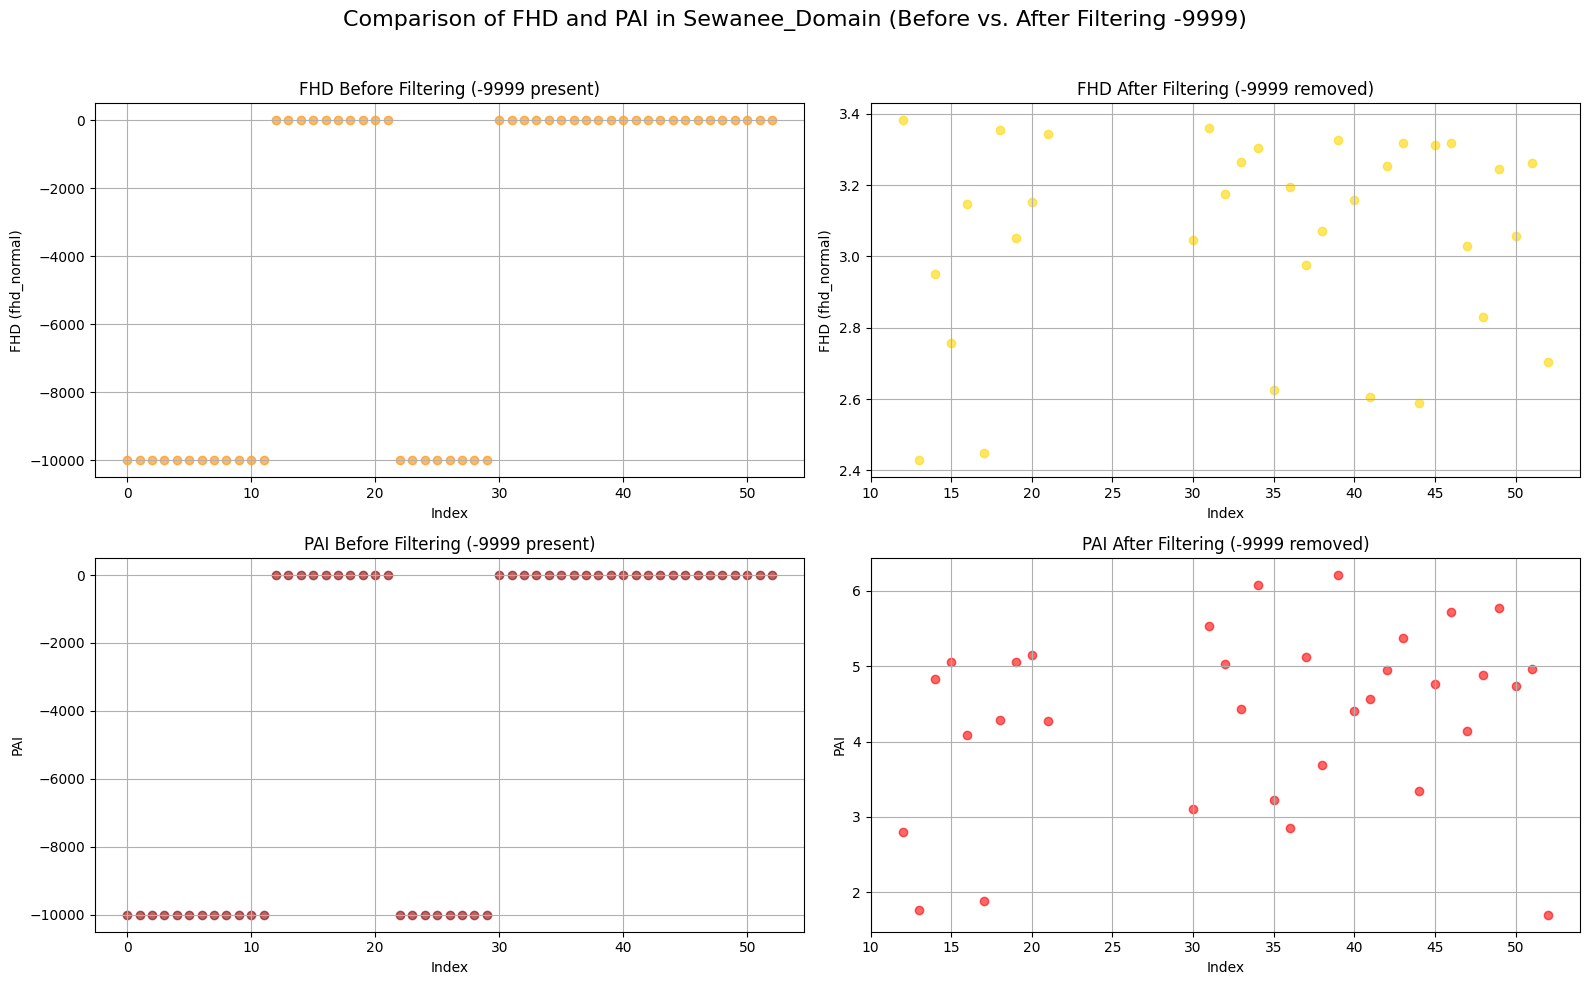

In [34]:
import matplotlib.pyplot as plt

# Filter out -9999 values
Sewanee_Domain_fhd_filtered = Sewanee_Domain[Sewanee_Domain['fhd_normal'] != -9999]
Sewanee_Domain_pai_filtered = Sewanee_Domain[Sewanee_Domain['pai'] != -9999]

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# --- Row 1: FHD (fhd_normal) ---
# Unfiltered
axes[0, 0].scatter(Sewanee_Domain.index, Sewanee_Domain['fhd_normal'], c='darkorange', alpha=0.6)
axes[0, 0].set_title('FHD Before Filtering (-9999 present)', fontsize=12)
axes[0, 0].set_ylabel('FHD (fhd_normal)')
axes[0, 0].set_xlabel('Index')
axes[0, 0].grid(True)

# Filtered
axes[0, 1].scatter(Sewanee_Domain_fhd_filtered.index, Sewanee_Domain_fhd_filtered['fhd_normal'], c='gold', alpha=0.6)
axes[0, 1].set_title('FHD After Filtering (-9999 removed)', fontsize=12)
axes[0, 1].set_ylabel('FHD (fhd_normal)')
axes[0, 1].set_xlabel('Index')
axes[0, 1].grid(True)

# --- Row 2: PAI ---
# Unfiltered
axes[1, 0].scatter(Sewanee_Domain.index, Sewanee_Domain['pai'], c='darkred', alpha=0.6)
axes[1, 0].set_title('PAI Before Filtering (-9999 present)', fontsize=12)
axes[1, 0].set_ylabel('PAI')
axes[1, 0].set_xlabel('Index')
axes[1, 0].grid(True)

# Filtered
axes[1, 1].scatter(Sewanee_Domain_pai_filtered.index, Sewanee_Domain_pai_filtered['pai'], c='red', alpha=0.6)
axes[1, 1].set_title('PAI After Filtering (-9999 removed)', fontsize=12)
axes[1, 1].set_ylabel('PAI')
axes[1, 1].set_xlabel('Index')
axes[1, 1].grid(True)

# Main title and layout
fig.suptitle('Comparison of FHD and PAI in Sewanee_Domain (Before vs. After Filtering -9999)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Filtered Data

Filter the FHD and PAI by dropping -9999 no data values

Filter our the quality flag to only include high qulaity obervations

In [35]:
# Create a new dictionary to hold the filtered GeoDataFrames
filtered_geo_dfs = {}

for aoi_name, gdf in geo_dfs.items():
    # Ensure required columns exist before filtering
    required_cols = ['l2b_quality_flag', 'fhd_normal', 'pai']
    if all(col in gdf.columns for col in required_cols):
        filtered = gdf[
            (gdf['l2b_quality_flag'] == 1) &
            (gdf['fhd_normal'] != -9999) &
            (gdf['pai'] != -9999)
        ].copy()
        filtered_geo_dfs[aoi_name] = filtered
        print(f"{aoi_name}: {len(filtered)} observations retained.")
    else:
        print(f"{aoi_name}: missing one or more required columns, skipped.")


SPB_AOI: 1371 observations retained.
Prescribed_Burn_AOI: 78 observations retained.
PaintRock_AOI: 6822 observations retained.
Sewanee_Domain: 31 observations retained.


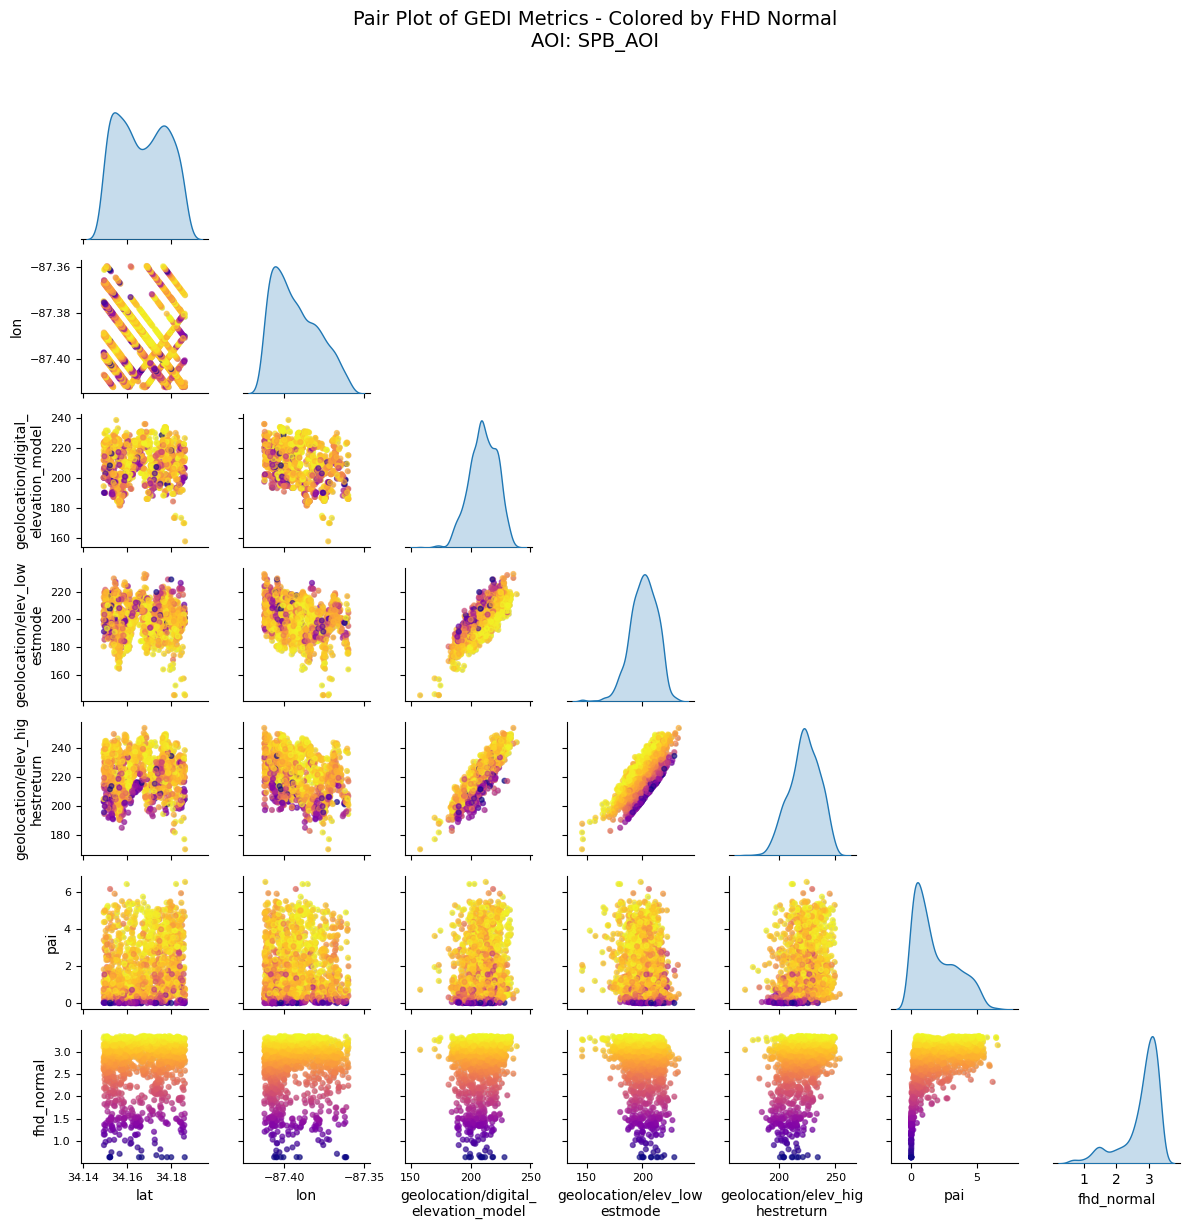

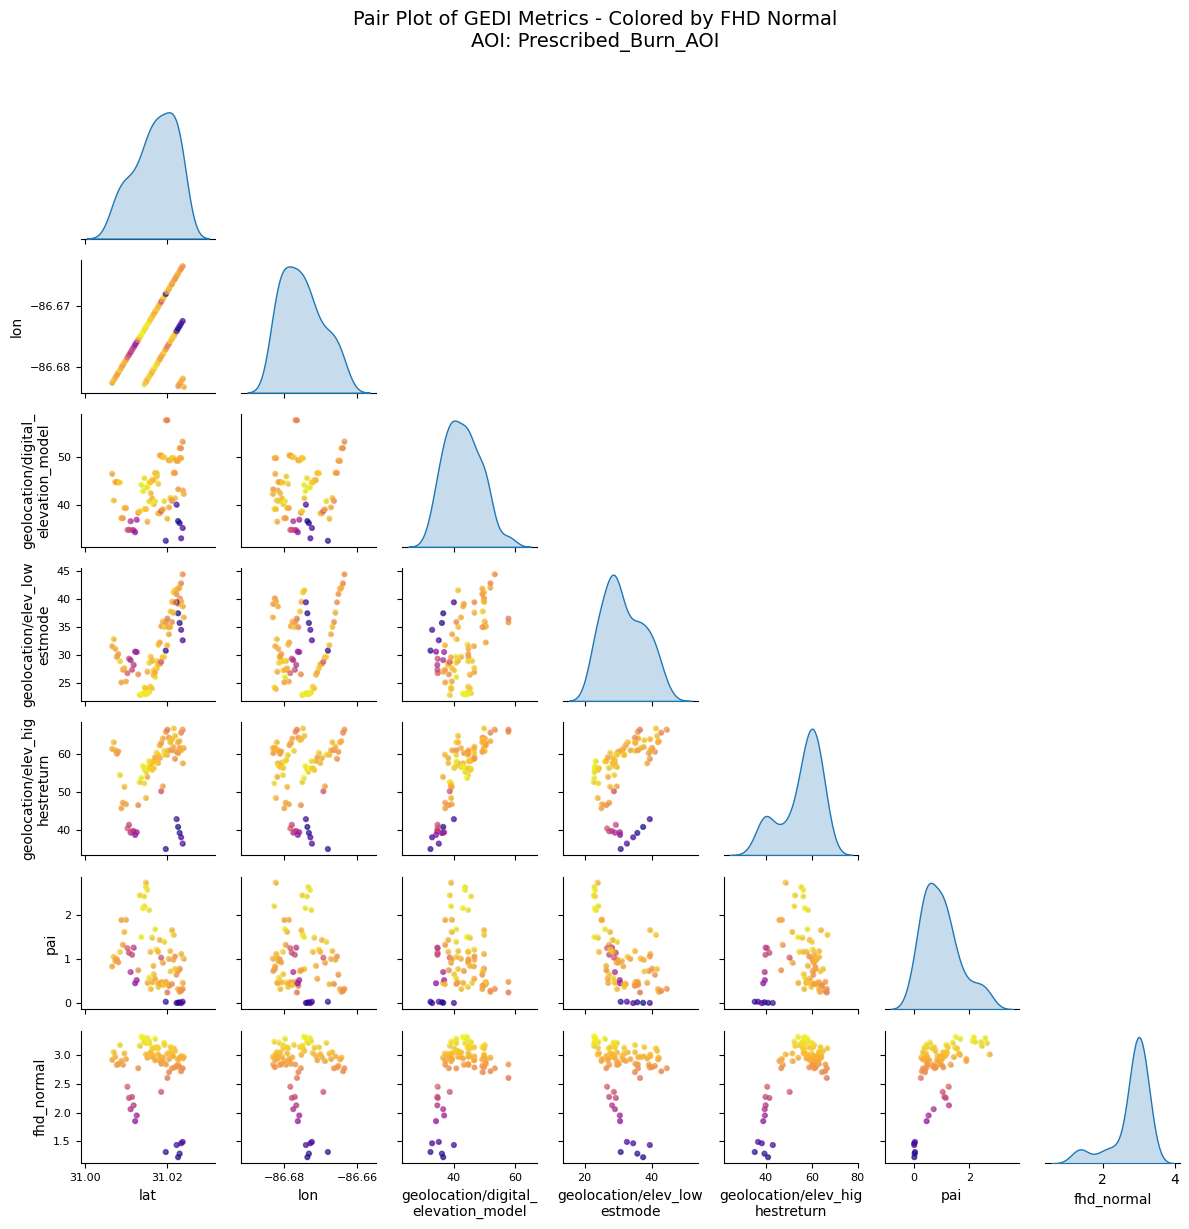

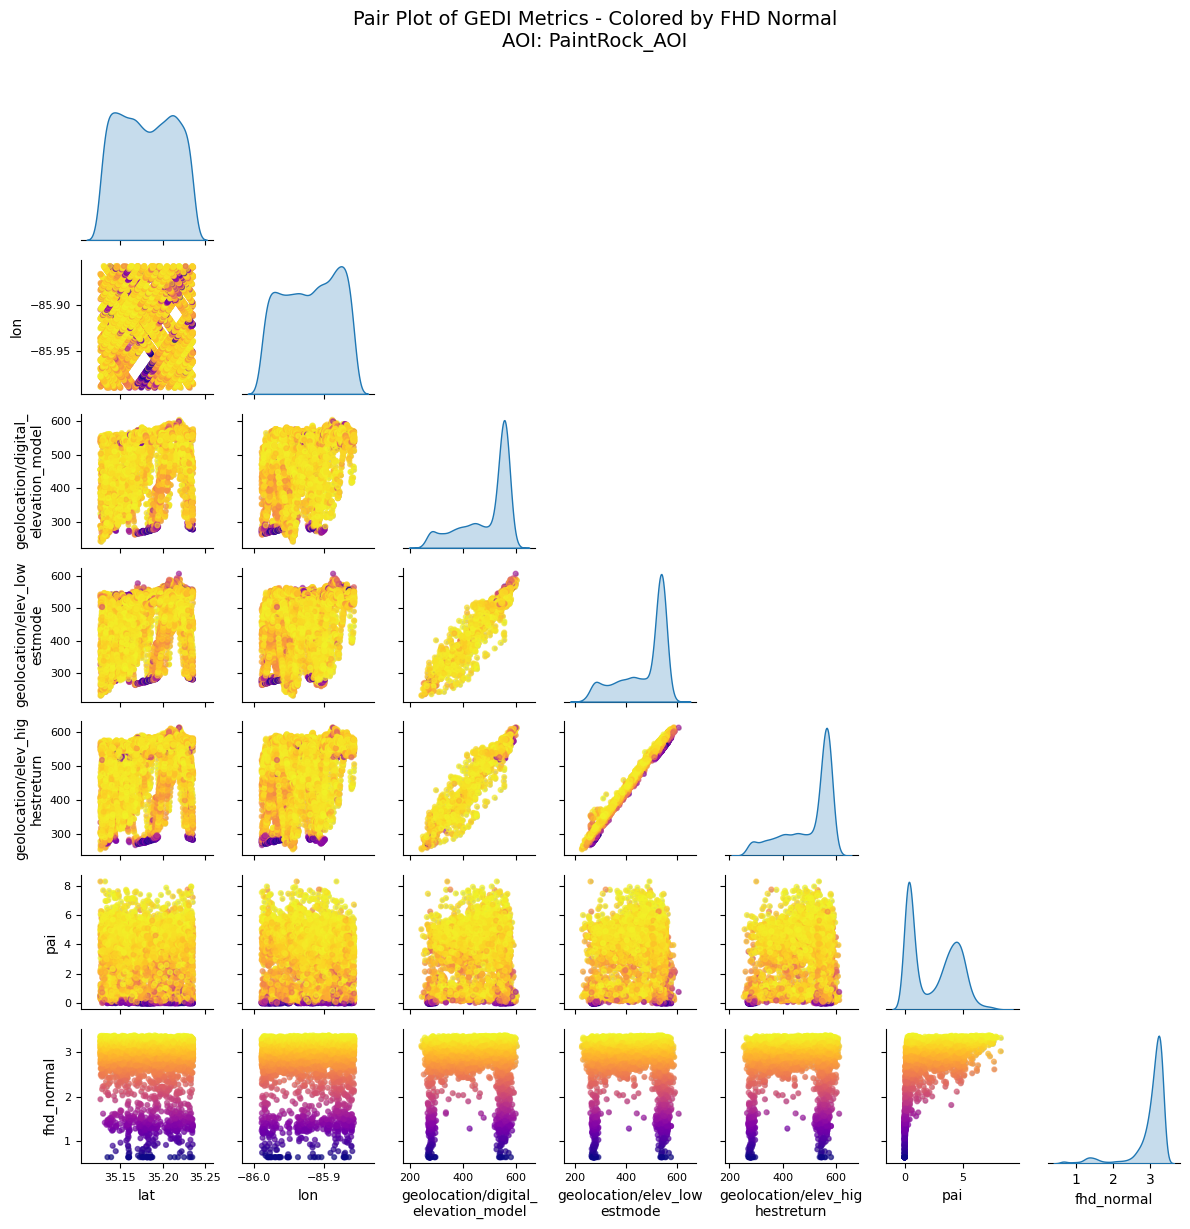

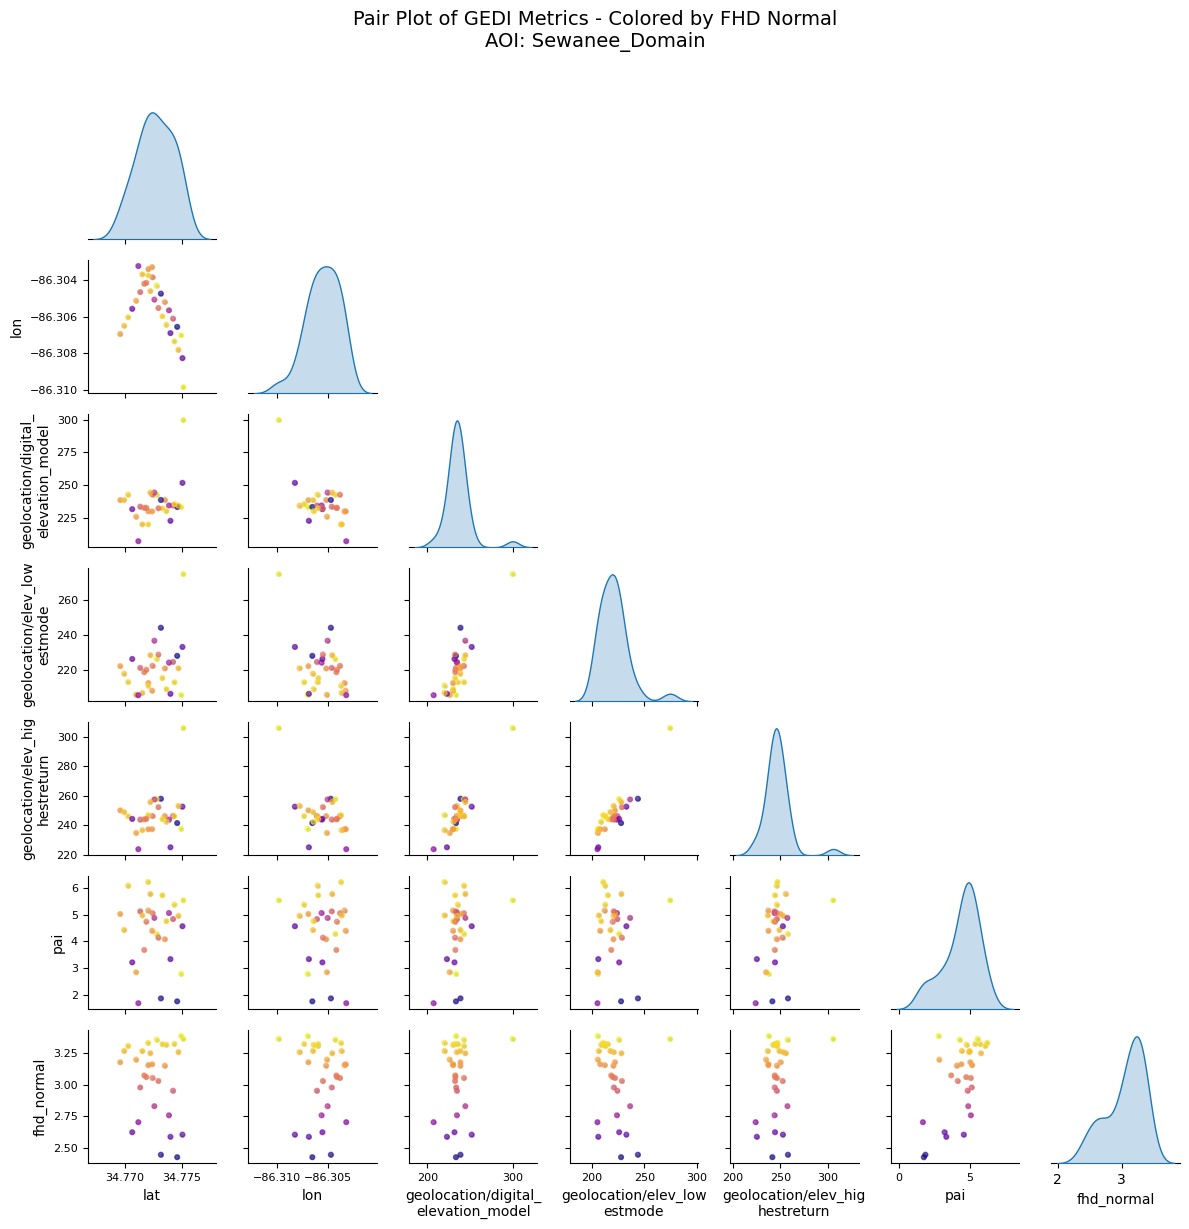

In [45]:
#### Pairplot on the filtered datasets

# Modern colormap access
cmap = mpl.colormaps['plasma']

for aoi_name, gdf in filtered_geo_dfs.items():
    numeric_cols = gdf.select_dtypes(include=[np.number]).columns.tolist()
    if 'fhd_normal' not in numeric_cols or gdf.empty:
        print(f"Skipping {aoi_name} (no numeric data or missing fhd_normal)")
        continue

    # Clean data
    plot_df = gdf[numeric_cols].dropna()

    # Normalize for coloring
    norm = Normalize(vmin=plot_df['fhd_normal'].min(), vmax=plot_df['fhd_normal'].max())
    colors = cmap(norm(plot_df['fhd_normal'].values))

    # Create base pairplot
    pair_grid = sns.pairplot(
        plot_df,
        corner=True,
        diag_kind='kde',
        plot_kws={'s': 10, 'alpha': 0.5, 'color': 'gray'},
        diag_kws={'fill': True}
    )

    # Resize figure for clarity
    pair_grid.fig.set_size_inches(12, 12)

    # Overlay color-coded scatter
    for i, j in zip(*np.tril_indices_from(pair_grid.axes, -1)):
        ax = pair_grid.axes[i, j]
        if ax:
            x = plot_df.iloc[:, j]
            y = plot_df.iloc[:, i]
            ax.scatter(x, y, c=colors, s=12, alpha=0.6)

            # Verbose wrapped labels
            ax.set_xlabel(textwrap.fill(plot_df.columns[j], 20), fontsize=10)
            ax.set_ylabel(textwrap.fill(plot_df.columns[i], 20), fontsize=10)
            ax.tick_params(labelsize=8)

    # Colorbar
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    # cbar = pair_grid.fig.colorbar(sm, ax=pair_grid.fig.axes, label='FHD Normal', shrink=0.7, pad=0.02)

    # Add title and adjust layout
    pair_grid.fig.suptitle(
        f"Pair Plot of GEDI Metrics - Colored by FHD Normal\nAOI: {aoi_name}",
        fontsize=14, y=1.02
    )
    pair_grid.fig.subplots_adjust(top=0.95, wspace=0.3, hspace=0.3)
    plt.tight_layout()
    plt.show()


In [38]:
SPB_AOI_filtered = filtered_geo_dfs.get('SPB_AOI', gp.GeoDataFrame())
Prescribed_Burn_AOI_filtered = filtered_geo_dfs.get('Prescribed_Burn_AOI', gp.GeoDataFrame())
PaintRock_AOI_filtered = filtered_geo_dfs.get('PaintRock_AOI', gp.GeoDataFrame())
Sewanee_Domain_filtered = filtered_geo_dfs.get('Sewanee_Domain', gp.GeoDataFrame())

Sewanee_Domain_filtered.head()

lat        lon geolocation/degrade_flag  \
12  34.774928 -86.307015                        0   
13  34.774582 -86.306556                        0   
14  34.774219 -86.306109                        0   
15  34.773859 -86.305660                        0   
16  34.773496 -86.305213                        0   

    geolocation/digital_elevation_model  geolocation/elev_lowestmode  \
12                           233.313324                   205.675064   
13                           233.313324                   227.876328   
14                           234.455063                   224.434616   
15                           234.455063                   224.022095   
16                           238.647110                   220.677078   

    geolocation/elev_highestreturn l2b_quality_flag rh100       pai  \
12                      237.709747                1  3202  2.798551   
13                      241.616150                1  1372  1.769525   
14                      246.351105                1  2190  4.834318   
15                      243.922409                1  1989  5.059941   
16                      246.364532                1  2568  4.083013   

    fhd_normal   product      Beam  \
12    3.381701  GEDI_L2B  BEAM1011   
13    2.428684  GEDI_L2B  BEAM1011   
14    2.951555  GEDI_L2B  BEAM1011   
15    2.758065  GEDI_L2B  BEAM1011   
16    3.148449  GEDI_L2B  BEAM1011   

                                             fileName                 date  \
12  GEDI02_B_2019168204100_O02904_03_T04427_02_003...  2019-06-17 20:41:00   
13  GEDI02_B_2019168204100_O02904_03_T04427_02_003...  2019-06-17 20:41:00   
14  GEDI02_B_2019168204100_O02904_03_T04427_02_003...  2019-06-17 20:41:00   
15  GEDI02_B_2019168204100_O02904_03_T04427_02_003...  2019-06-17 20:41:00   
16  GEDI02_B_2019168204100_O02904_03_T04427_02_003...  2019-06-17 20:41:00   

                      geometry  
12  POINT (-86.30702 34.77493)  
13  POINT (-86.30656 34.77458)  
14  POINT (-86.30611 34.77422)  
15  POINT (-86.30566 34.77386)  
16   POINT (-86.30521 34.7735)

# Plot and Explore the data

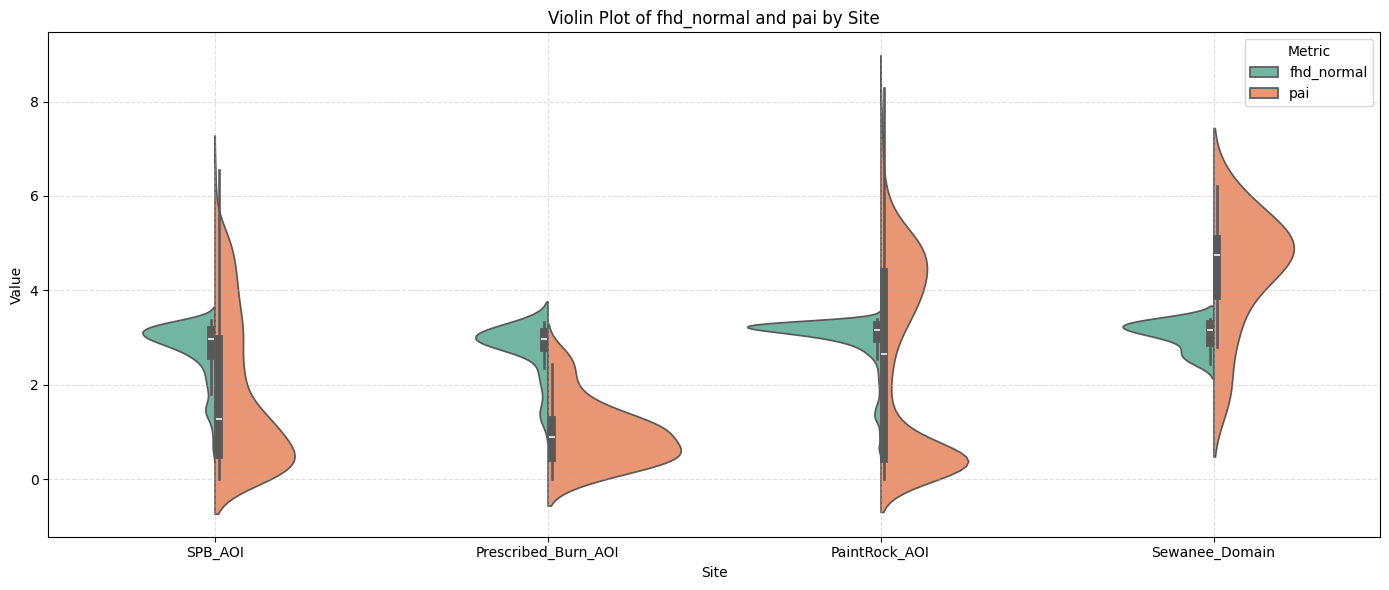

In [39]:
## create violin plots for PAI and FHD per AOI
# Prepare data from filtered_geo_dfs
fhd_data = []
pai_data = []

for site, gdf in filtered_geo_dfs.items():
    if not gdf.empty:
        if 'fhd_normal' in gdf.columns:
            temp_fhd = gdf[['fhd_normal']].copy()
            temp_fhd['site'] = site
            temp_fhd['metric'] = 'fhd_normal'
            temp_fhd.rename(columns={'fhd_normal': 'value'}, inplace=True)
            fhd_data.append(temp_fhd)

        if 'pai' in gdf.columns:
            temp_pai = gdf[['pai']].copy()
            temp_pai['site'] = site
            temp_pai['metric'] = 'pai'
            temp_pai.rename(columns={'pai': 'value'}, inplace=True)
            pai_data.append(temp_pai)

# Combine both metrics
combined_df = pd.concat(fhd_data + pai_data, ignore_index=True)

# Plot as violin plots
plt.figure(figsize=(14, 6))
sns.violinplot(data=combined_df, x='site', y='value', hue='metric', palette='Set2', split=True)
plt.title("Violin Plot of fhd_normal and pai by Site")
plt.ylabel("Value")
plt.xlabel("Site")
plt.legend(title="Metric")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
## Map both FHD and PAI per AOI
## explore the map and click on the observatiosn to diplay the values

# Initialize map centered on average coordinates of all sites combined
all_lats = []
all_lons = []

for df in filtered_geo_dfs.values():
    all_lats.extend(df['lat'].tolist())
    all_lons.extend(df['lon'].tolist())

map_center = [sum(all_lats) / len(all_lats), sum(all_lons) / len(all_lons)]
m = folium.Map(location=map_center, zoom_start=8)

# Define colormap and normalization globally for consistent coloring

# Combine all FHD and PAI values for normalization
all_fhd_values = pd.concat([df['fhd_normal'] for df in filtered_geo_dfs.values()])
all_pai_values = pd.concat([df['pai'] for df in filtered_geo_dfs.values()])

norm_fhd = colors.Normalize(vmin=all_fhd_values.min(), vmax=all_fhd_values.max())
norm_pai = colors.Normalize(vmin=all_pai_values.min(), vmax=all_pai_values.max())
cmap = cm.get_cmap('viridis')

# Add each AOI as separate FeatureGroups for FHD and PAI
for site_name, df in filtered_geo_dfs.items():
    fg_fhd = folium.FeatureGroup(name=f"{site_name} - FHD")
    fg_pai = folium.FeatureGroup(name=f"{site_name} - PAI")

    for _, row in df.iterrows():
        lat, lon = row['lat'], row['lon']

        # FHD marker
        fhd_value = row['fhd_normal']
        if pd.notnull(fhd_value):
            color_fhd = colors.to_hex(cmap(norm_fhd(fhd_value)))
            folium.CircleMarker(
                location=(lat, lon),
                radius=3,
                color=color_fhd,
                fill=True,
                fill_color=color_fhd,
                fill_opacity=0.8,
                popup=f"FHD: {fhd_value:.2f}"
            ).add_to(fg_fhd)

        # PAI marker
        pai_value = row['pai']
        if pd.notnull(pai_value):
            color_pai = colors.to_hex(cmap(norm_pai(pai_value)))
            folium.CircleMarker(
                location=(lat, lon),
                radius=3,
                color=color_pai,
                fill=True,
                fill_color=color_pai,
                fill_opacity=0.8,
                popup=f"PAI: {pai_value:.2f}"
            ).add_to(fg_pai)

    fg_fhd.add_to(m)
    fg_pai.add_to(m)

# Add layer control to toggle layers on/off
folium.LayerControl(collapsed=False).add_to(m)

# Save and display
m.save('filtered_gedi_fhd_pai_map.html')
m


In [ ]:
## 3D plots of quality filtered FHD and PAI

# Prepare figure with 2 rows (FHD on top, PAI below), columns = number of AOIs
num_aois = len(filtered_geo_dfs)
fig = plt.figure(figsize=(5 * num_aois, 10))  # width scaled by number of AOIs, height for 2 rows

# Find global min/max for color normalization for fhd_normal and pai
fhd_min = min(df['fhd_normal'].min() for df in filtered_geo_dfs.values())
fhd_max = max(df['fhd_normal'].max() for df in filtered_geo_dfs.values())
pai_min = min(df['pai'].min() for df in filtered_geo_dfs.values())
pai_max = max(df['pai'].max() for df in filtered_geo_dfs.values())

for i, (aoi_name, df) in enumerate(filtered_geo_dfs.items(), start=1):
    # Top row: fhd_normal scatter
    ax1 = fig.add_subplot(2, num_aois, i, projection='3d')
    x = df['lat']
    y = df['lon']
    z = df['fhd_normal']
    colors = z
    scatter = ax1.scatter(x, y, z, c=colors, cmap='viridis', s=5, vmin=fhd_min, vmax=fhd_max)
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel('Longitude')
    ax1.set_zlabel('fhd_normal')
    ax1.set_title(f"{aoi_name} - FHD")
    ax1.set_zlim(fhd_min, fhd_max)

    # Bottom row: pai scatter
    ax2 = fig.add_subplot(2, num_aois, i + num_aois, projection='3d')
    z2 = df['pai']
    colors2 = z2
    scatter2 = ax2.scatter(x, y, z2, c=colors2, cmap='plasma', s=5, vmin=pai_min, vmax=pai_max)
    ax2.set_xlabel('Latitude')
    ax2.set_ylabel('Longitude')
    ax2.set_zlabel('pai')
    ax2.set_title(f"{aoi_name} - PAI")
    ax2.set_zlim(pai_min, pai_max)

# Add shared colorbars on right side
cbar_ax_fhd = fig.add_axes([0.92, 0.55, 0.015, 0.35])
norm_fhd = plt.Normalize(vmin=fhd_min, vmax=fhd_max)
cbar_fhd = plt.colorbar(plt.cm.ScalarMappable(norm=norm_fhd, cmap='viridis'), cax=cbar_ax_fhd)
cbar_fhd.set_label('fhd_normal')

cbar_ax_pai = fig.add_axes([0.92, 0.1, 0.015, 0.35])
norm_pai = plt.Normalize(vmin=pai_min, vmax=pai_max)
cbar_pai = plt.colorbar(plt.cm.ScalarMappable(norm=norm_pai, cmap='plasma'), cax=cbar_ax_pai)
cbar_pai.set_label('pai')

plt.suptitle('3D Visualization of fhd_normal and pai per AOI (filtered)', fontsize=18)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()


In [ ]:
import holoviews as hv
hv.extension('bokeh')

def plot_transect_elevations(filtered_gdf, transect_col='Beam', output_title_prefix='GEDI Beam'):
    """
    Generate elevation transect plots per unique beam in the dataframe.

    Parameters:
    - filtered_gdf: pd.DataFrame or GeoDataFrame with GEDI data.
    - transect_col: str, name of column identifying beam/transect (default: 'Beam')
    - output_title_prefix: str, prefix for plot titles (default: 'GEDI Beam')

    Returns:
    - plots_dict: dict of {beam_name: hv.Overlay} of the combined scatter plots
    """
    plots_dict = {}

    for transect_name, group_df in filtered_gdf.groupby(transect_col):
        group_df = group_df.dropna(subset=[
            'geolocation/digital_elevation_model',
            'geolocation/elev_lowestmode',
            'geolocation/elev_highestreturn'
        ]).copy()

        x_vals = range(len(group_df))

        demVis = hv.Scatter((x_vals, group_df['geolocation/digital_elevation_model']),
                            label='DEM (GEDI)').opts(color='black', size=1.5)

        zVis = hv.Scatter((x_vals, group_df['geolocation/elev_lowestmode']),
                          label='Elev lowestmode -> Lowest Mode Elevation').opts(color='saddlebrown', size=1.5)

        rhVis = hv.Scatter((x_vals, group_df['geolocation/elev_highestreturn']),
                           label='Highest Return -> Canopy Top Elevation').opts(color='darkgreen', size=1.5, tools=['hover'])

        combined = (demVis * zVis * rhVis).opts(
            title=f'{output_title_prefix} {transect_name} Elevation Profile',
            height=500, width=900,
            show_legend=True, legend_position='top_left',
            xlabel='Observation Index', ylabel='Elevation (m)',
            fontsize={'title': 14, 'xlabel': 16, 'ylabel': 16}
        )

        plots_dict[transect_name] = combined

    return plots_dict

# Apply to each AOI in filtered_geo_dfs (already cleaned)
all_plots = {}

for aoi_name, gdf in filtered_geo_dfs.items():
    if gdf.empty:
        print(f"No valid data for {aoi_name}")
        continue

    plots = plot_transect_elevations(gdf, transect_col='Beam', output_title_prefix=f'GEDI {aoi_name}')
    all_plots[aoi_name] = plots

# Example: display all transects for one AOI, e.g., 'SPB_AOI'
if 'SPB_AOI' in all_plots:
    hv.Layout(all_plots['SPB_AOI'].values()).cols(1)


In [ ]:
# plot elevation per beam i.e Beam1011 and per AOI.
# Press enter to procude the next set of plots
# these charts are interactive, zoom in and out to explore the data further

for aoi_name, plots_dict in all_plots.items():
    print(f"Displaying transect plots for AOI: {aoi_name}")
    layout = hv.Layout(plots_dict.values()).cols(1)
    display(layout)  # In Jupyter/Colab this will render the plot
    # Optionally add a pause or break here to show one AOI at a time
    input("Press Enter to continue to the next AOI...")


##Contact Info:

Email: timothy.j.mayer@nasa.gov

Organization: SERVIR & Earth Hub

Website: XXXXXXXX

Date last modified: 06-25-2025


Funding for this work was provided through the cooperative agreement 80MSFC22N0004 between NASA and UAH. SERVIR is a joint NASA- and USAID-led program